# 1. Import libs

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import settings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Load and explore Data

In [2]:
df_train = pd.read_csv(settings.train_path)
df_test = pd.read_csv(settings.test_path)

print(df_train.head())

         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000


In [3]:
df_train.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [4]:
df_test.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [5]:
df_train.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


## 2.1. Make lags

Since we are dealing with time series, lets try to solve the problem using the time lags of the 2 preceding days (lags beyond that dont make much sense)  

In [6]:
def make_lags(data: pd.DataFrame, columns: list, start_lag: int, end_lag: int) -> pd.DataFrame: 
    """
    Creates lagged features

    Parameters:
    - data: dataframe to add lagged features
    - columns: list of columns to add lagged features
    - start_lag: start lag of lagged features
    - end_lag: end lag of lagged features

    Returns:
    - preprocessed_data: dataframe with lagged features
    """
    for lag in range(start_lag, end_lag + 1):
        for col in columns:
            data[col+'_'+str(lag)] = data[col].shift(lag)
    return data

In [7]:
df_train = make_lags(df_train, ['meantemp'], 1, 2)
df_test = make_lags(df_test, ['meantemp'], 1, 2)
df_train = df_train.dropna()
df_test = df_test.dropna()

Now explore date with correlation matrix, as we intend to construct linear models.

<Axes: >

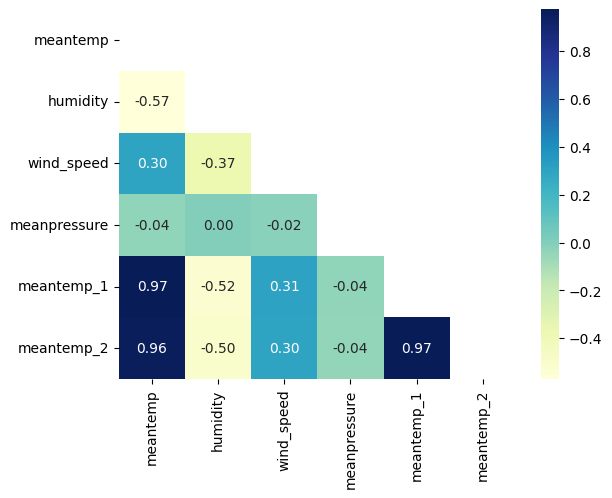

In [8]:
corr = df_train.drop(['date'], axis=1).corr()
# mask for bottom triangle in correlation matrix
coor_mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=coor_mask, annot=True, fmt=".2f", cmap="YlGnBu")

# 3. Preprocessing data

Lets split and standard our data. In feature we get all feature except data, our target and not uninformative feature 'meanpressure'

In [9]:
X_train = df_train.drop(['date', 'meantemp', 'meanpressure'], axis=1)
y_train = df_train['meantemp'].copy()
X_test = df_test.drop(['date', 'meantemp', 'meanpressure'], axis=1)
y_test = df_test['meantemp'].copy()
# scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 4. Model traning

Since in our case there is a very strong correlation between lags and fixes, it makes sense to try an ordinary linear model

In [10]:
linear = LinearRegression()
linear.fit(X_train, y_train)
y_predict = linear.predict(X_test)
# use 2 metrics root of squared error and mean absolute percentage error for better understanding reusults
print('Test error on linear regression RMSE: ',
      round(np.sqrt(mean_squared_error(y_test, y_predict)), 3),
      ', MAPE: ',
      round(mean_absolute_percentage_error(y_test, y_predict), 3), '%', sep='')

Test error on linear regression RMSE: 1.585, MAPE: 0.061%


# 5. Conclusions

As a result, we got excellent metrics on the results of a simple linear model, if we visualize our test dataset, we see the following picture. 

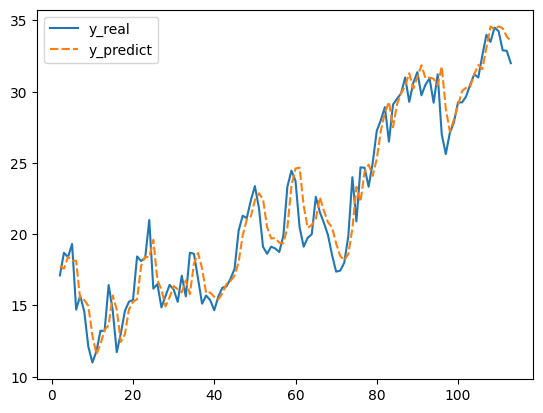

In [11]:
df_to_plot = pd.DataFrame({'date': df_test['date'], 'y_real': y_test, 'y_predict': y_predict})

sns.lineplot(data=df_to_plot[['date', 'y_real', 'y_predict']])

plt.show()

Lets display the importance of attributes using linear regression coefficients. In general, the picture repeats the correlation matrix (which is not surprising for a linear model) and does not carry any special information. 

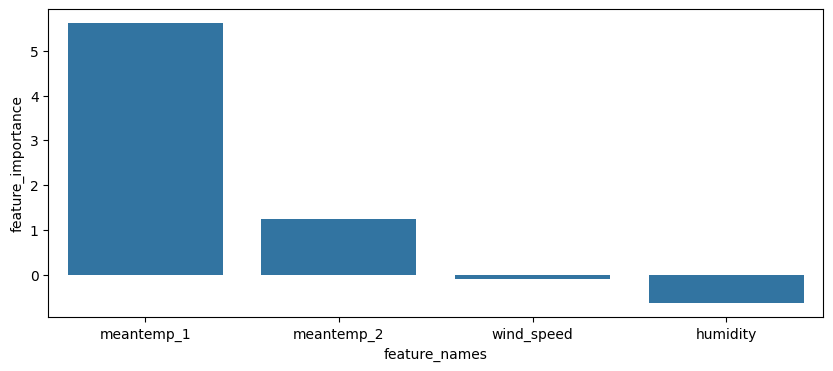

In [12]:
feature_importance = pd.DataFrame({'feature_names':df_test.drop(['date', 'meantemp', 'meanpressure'], axis=1).columns,
                                   'feature_importance':linear.coef_})
feature_importance = feature_importance.sort_values(by=['feature_importance'], ascending=False)

plt.figure(figsize=(10,4))

sns.barplot(y=feature_importance['feature_importance'], x=feature_importance['feature_names'], orient='v')
plt.show()

# 6. Saving model

In [13]:
with open(settings.model_path, 'wb') as pkl:
    pickle.dump(linear, pkl)

with open(settings.scaler_path, 'wb') as pkl:
    pickle.dump(scaler, pkl)